In [1]:
import torch
from UNet import UNet

In [2]:
unet = UNet(2)

In [17]:
from PIL import Image

In [18]:
import numpy as np

In [26]:
img = torch.tensor(np.asarray(Image.open("dataset/train_hq/00087a6bd4dc_01.jpg")),dtype=torch.float)
img = img.reshape([1,3,*(img.shape[:2])])


In [27]:
img.shape

torch.Size([1, 3, 1280, 1918])

In [28]:
mask = unet.forward(img)

In [29]:
mask.shape

torch.Size([1, 2, 1280, 1918])

In [31]:
mask = mask.detach().numpy()

In [32]:
import matplotlib.pyplot as plt

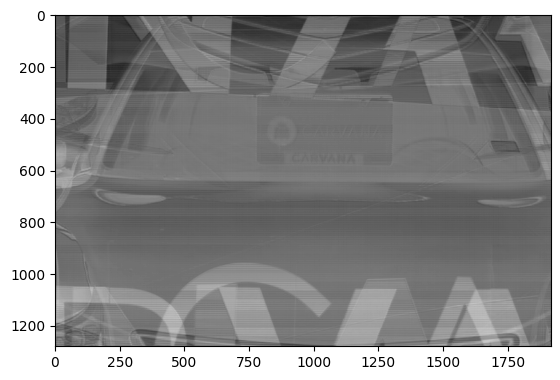

In [34]:
plt.imshow(mask[0,1,:,:],cmap="gray")